In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale

In [2]:
class Topsis:
    def __init__(self, X, weights, criteria):
        self.X = np.asarray(X, dtype="float64")
        self.weights = np.asarray(weights, dtype="float64")
        self.weights /= np.sum(self.weights)
        self.criteria = np.asarray(criteria, dtype=bool)
        self._fitted = False

    def fit(self):
        X_norm = self.X.copy()
        norm_coefs = np.sum(X_norm**2, axis=0) ** 0.5
        X_norm /= norm_coefs
        X_norm *= self.weights

        # Determine the best and worst alternatives
        X_min, X_max = X_norm.min(axis=0), X_norm.max(axis=0)
        best = np.where(self.criteria, X_max, X_min)
        worst = np.where(self.criteria, X_min, X_max)

        # Determine the best and worst distances
        self.best_distance = np.sum((X_norm - best) ** 2, axis=1) ** 0.5
        self.worst_distance = np.sum((X_norm - worst) ** 2, axis=1) ** 0.5
        self._fitted = True

    def predict(self):
        if not self._fitted:
            raise ValueError("The model has not been fitted yet")
        denom = self.best_distance + self.worst_distance
        return self.best_distance / denom, self.worst_distance / denom

    def fit_predict(self):
        if not self._fitted:
            self.fit()
        return self.predict()

In [3]:
def get_performance(df, match_id):
    match_df = df[df["match_id"] == match_id]
    eval_df = match_df.copy()

    # Explode the columns to duplicate columns for each player
    eval_df["player_id"] = None
    for i in eval_df.index:
        eval_df.at[i, "player_id"] = (1, 2)
    eval_df = (
        eval_df.explode("player_id")
        .reset_index(names="point_id")
        .set_index(["point_id", "player_id"])
    )

    # Assign info to the corresponding player
    sep_cols = ["ace", "winner", "break_pt_won", "double_fault", "unf_err"]
    eval_df_spec_criteria = [True, True, True, False, False]
    for col in sep_cols:
        eval_df[col] = eval_df.apply(lambda x: x[f"p{x.name[1]}_{col}"], axis=1)

    # Victor by server or receiver
    eval_df["victor_by_server"] = eval_df.apply(
        lambda x: int(x["point_victor"] == x.name[1] and x["server"] == x.name[1]),
        axis=1,
    )
    eval_df["victor_by_receiver"] = eval_df.apply(
        lambda x: int(x["point_victor"] == x.name[1] and x["server"] != x.name[1]),
        axis=1,
    )
    sep_cols = ["victor_by_server", "victor_by_receiver"] + sep_cols
    eval_df_spec_criteria = [True, True] + eval_df_spec_criteria

    # Entropy weight method (EWM)
    eval_df_spec = eval_df[sep_cols]
    scaled_values = minmax_scale(eval_df_spec.values, feature_range=(0.01, 0.99))
    norm_values = scaled_values / np.sum(scaled_values, axis=0)
    g = 1 + 1 / np.log(len(eval_df_spec)) * np.sum(
        norm_values * np.log(norm_values), axis=0
    )
    eval_df_spec_weights = g / np.sum(g)

    # TOPSIS
    topsis = Topsis(eval_df_spec.values, eval_df_spec_weights, eval_df_spec_criteria)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        eval_df_spec["performance"] = topsis.fit_predict()[1]

    # Store performance data
    p1_performance = eval_df_spec.loc[
        eval_df_spec.index.get_level_values("player_id") == 1, "performance"
    ]
    p2_performance = eval_df_spec.loc[
        eval_df_spec.index.get_level_values("player_id") == 2, "performance"
    ]
    p1_performance.index = p1_performance.index.droplevel("player_id")
    p2_performance.index = p2_performance.index.droplevel("player_id")
    return pd.concat([p1_performance, p2_performance], axis=1, keys=["p1", "p2"])

In [4]:
df = pd.read_csv("wimbledon.csv")

In [5]:
def plot_match_info(df, *, n_samples, window_size):
    rng = np.random.RandomState(42)
    match_ids = df["match_id"].unique()
    if n_samples is not None:
        match_ids = rng.choice(match_ids, size=n_samples, replace=False)
    for match_id in match_ids:
        _, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

        # Performance
        df_performance = get_performance(df, match_id)
        ax1.plot(df_performance.index, df_performance["p1"], label="Player 1")
        ax1.plot(df_performance.index, df_performance["p2"], label="Player 2")
        ax1.set_title("Performance", fontsize=10)
        ax1.get_xaxis().set_visible(False)
        ax1.legend(loc="lower right")

        # Momentum
        df_perf_diff = df_performance["p1"] - df_performance["p2"]
        ser_momentum = df_perf_diff.rolling(window_size).sum()
        ser_momentum = ser_momentum.fillna(df_perf_diff.cumsum())
        ax2.plot(ser_momentum.index, ser_momentum, color="black")
        ax2.fill_between(
            ser_momentum.index,
            ser_momentum,
            where=ser_momentum > 0,
            color="tab:blue",
            alpha=0.3,
            interpolate=True,
        )
        ax2.fill_between(
            ser_momentum.index,
            ser_momentum,
            where=ser_momentum < 0,
            color="tab:orange",
            alpha=0.3,
            interpolate=True,
        )
        for i, sign_diff in (
            np.sign(ser_momentum).diff().where(lambda x: x != 0).dropna().items()
        ):
            ax2.axvline(
                i,
                color="tab:orange" if sign_diff < 0 else "tab:blue",
                linestyle="--",
                lw=0.3,
            )
        ax2.set_title("Momentum", fontsize=10)
        ax2.get_xaxis().set_visible(False)

        # Points
        df_points_info = df.loc[
            ser_momentum.index, ["point_victor", "p1_points_won", "p2_points_won"]
        ]
        ser_points_diff = (
            df_points_info["p1_points_won"] - df_points_info["p2_points_won"]
        )
        ax3.fill_between(
            ser_points_diff.index,
            ser_points_diff,
            where=ser_points_diff > 0,
            color="tab:blue",
            alpha=0.1,
            interpolate=True,
        )
        ax3.fill_between(
            ser_points_diff.index,
            ser_points_diff,
            where=ser_points_diff < 0,
            color="tab:orange",
            alpha=0.1,
            interpolate=True,
        )
        ser_victor = df_points_info["point_victor"]
        ser_victor_p1 = ser_victor.copy()
        ser_victor_p1[ser_victor == 1] = 1
        ser_victor_p1[ser_victor != 1] = 0
        ax3.fill_between(
            ser_victor.index,
            ser_victor_p1,
            color="tab:blue",
            step="post",
            alpha=0.5,
        )
        ser_victor_p2 = ser_victor.copy()
        ser_victor_p2[ser_victor == 2] = -1
        ser_victor_p2[ser_victor != 2] = 0
        ax3.fill_between(
            ser_victor.index,
            ser_victor_p2,
            color="tab:orange",
            step="post",
            alpha=0.5,
        )
        ax3.set_ylim(-10, 10)
        ax3.set_title("Points", fontsize=10)
        ax3.get_xaxis().set_visible(False)

        plt.suptitle(f"Match {match_id}")
        plt.tight_layout()
        plt.show()

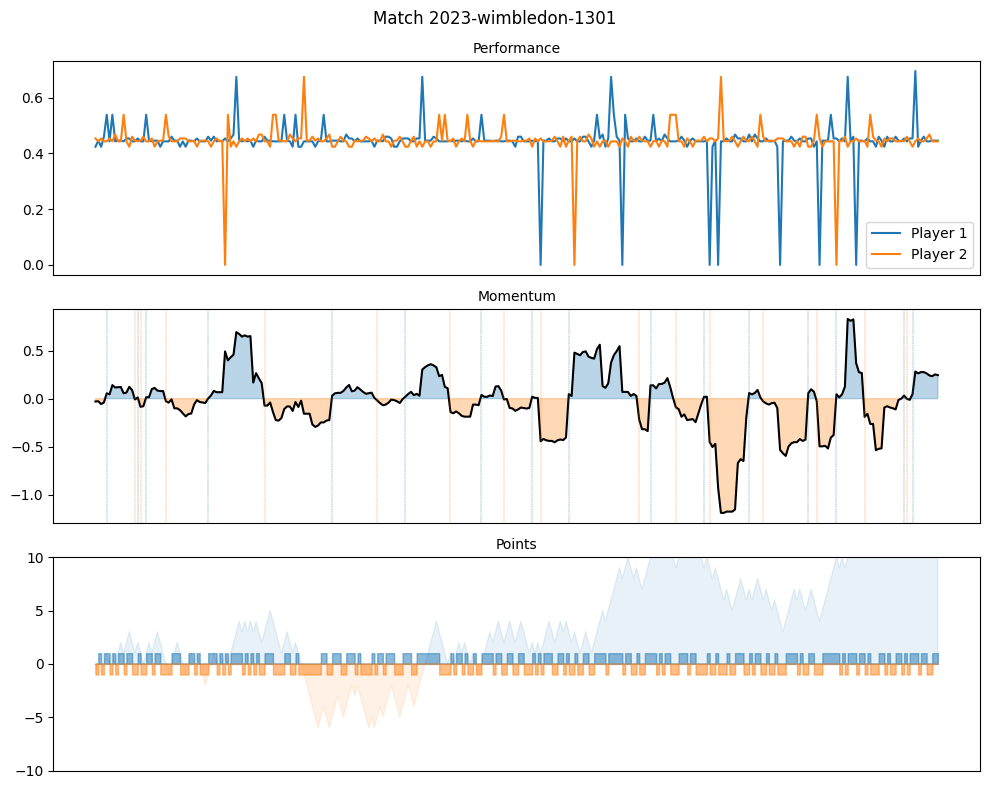

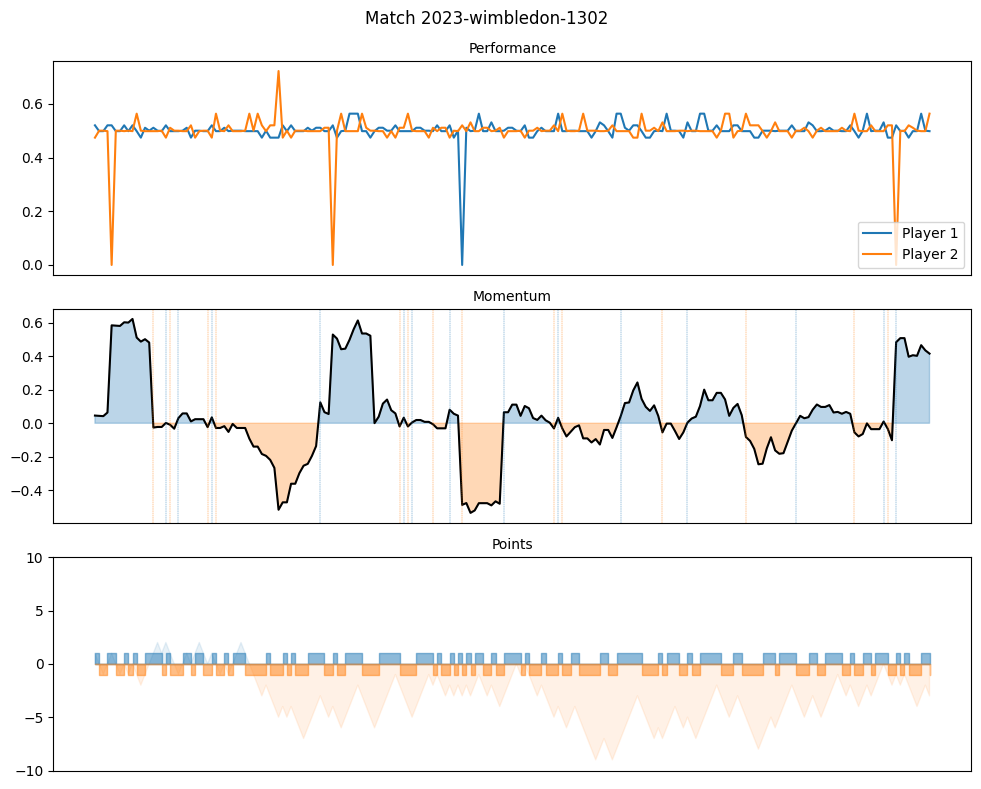

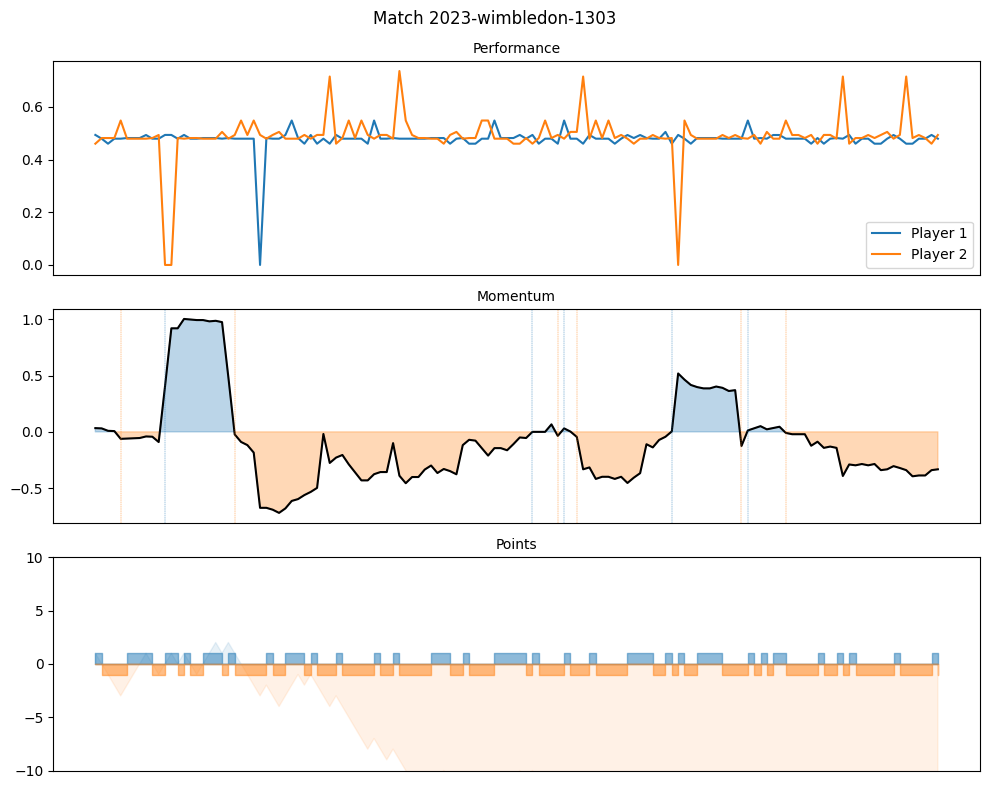

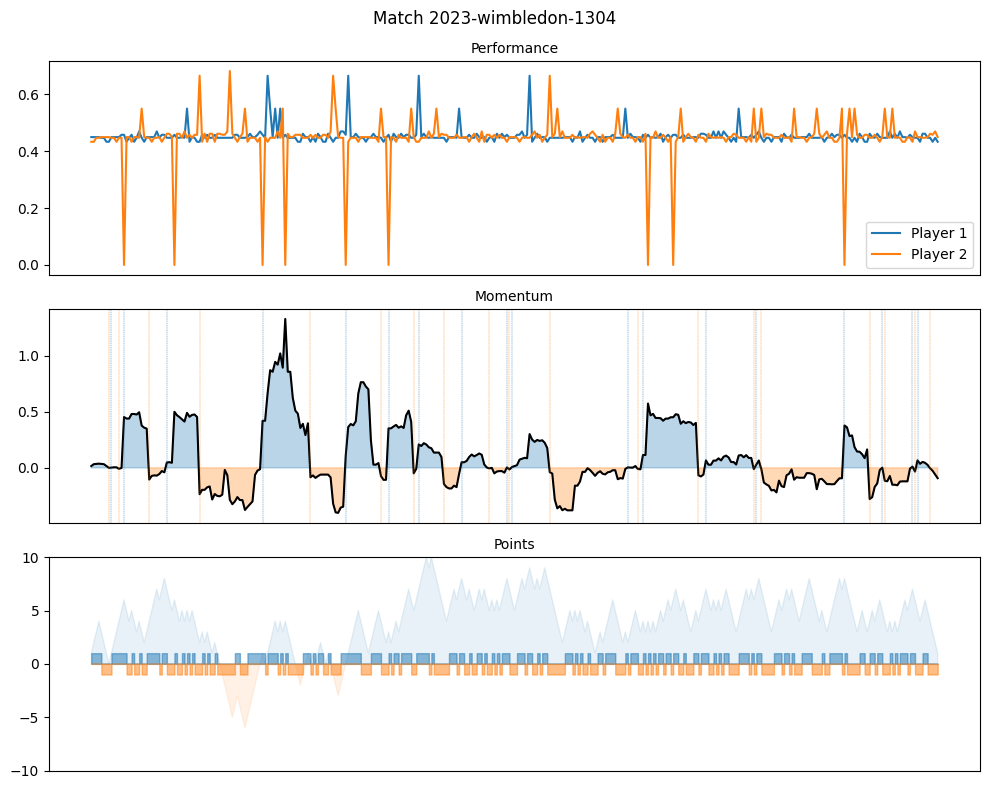

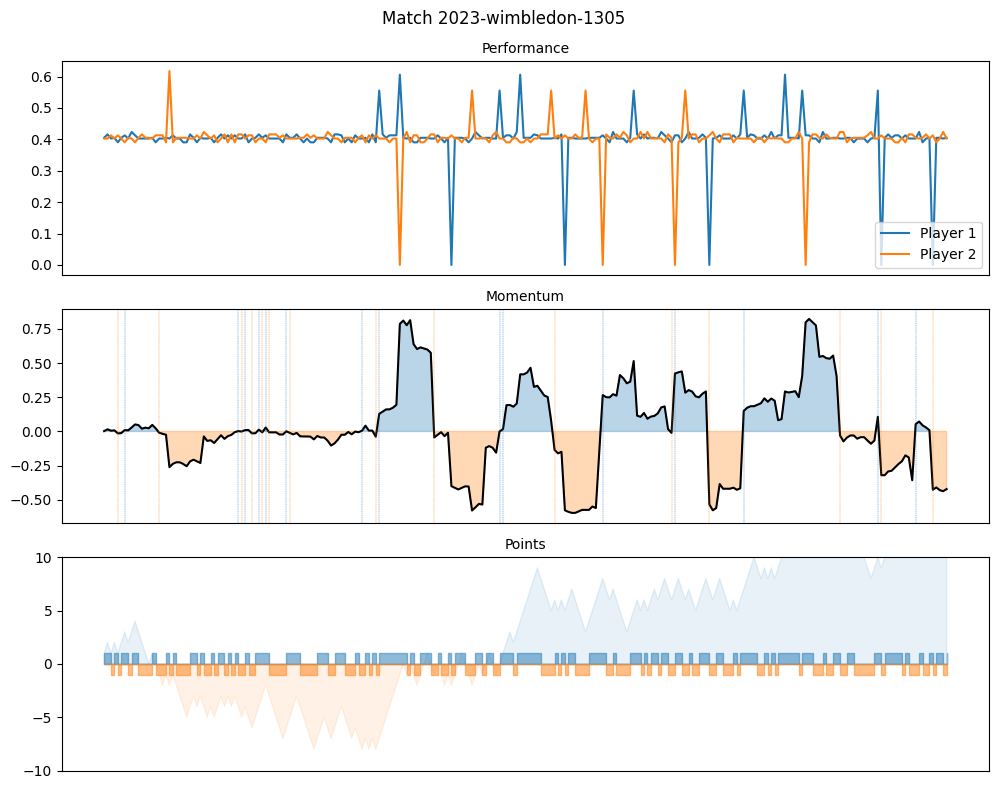

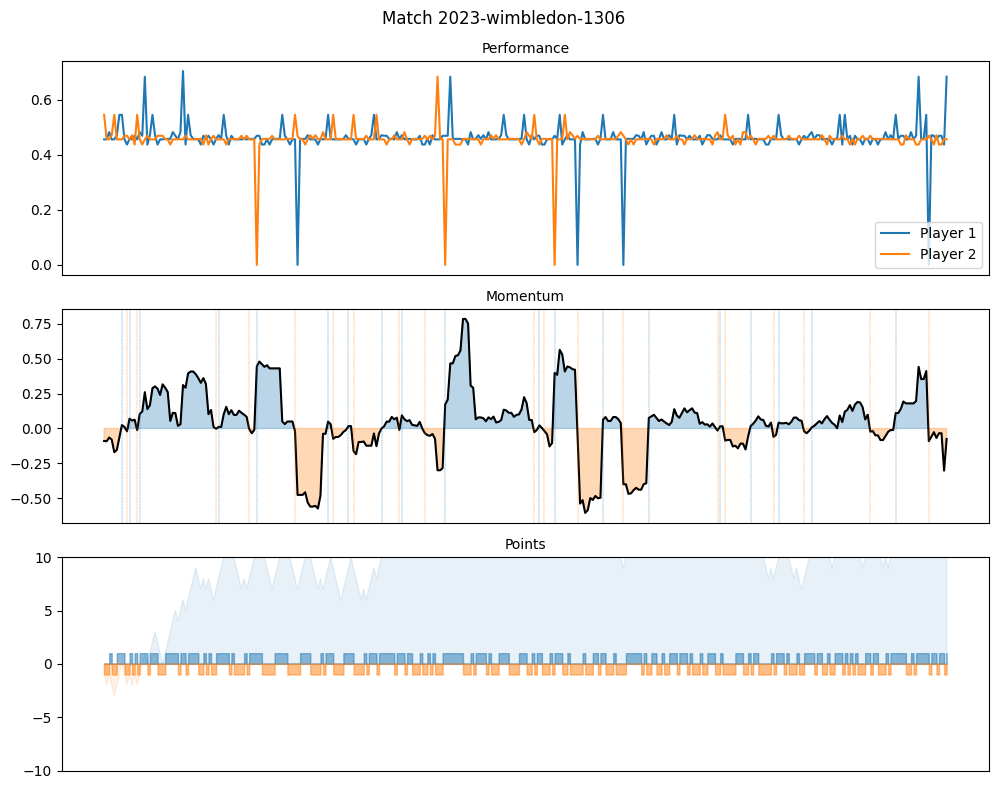

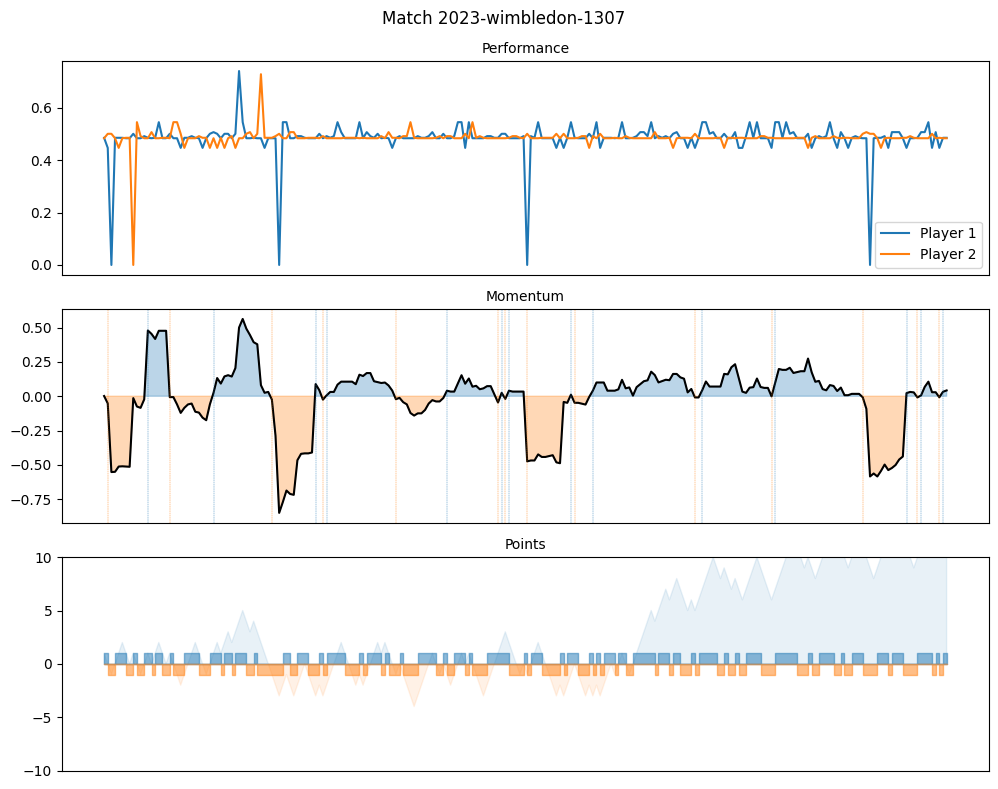

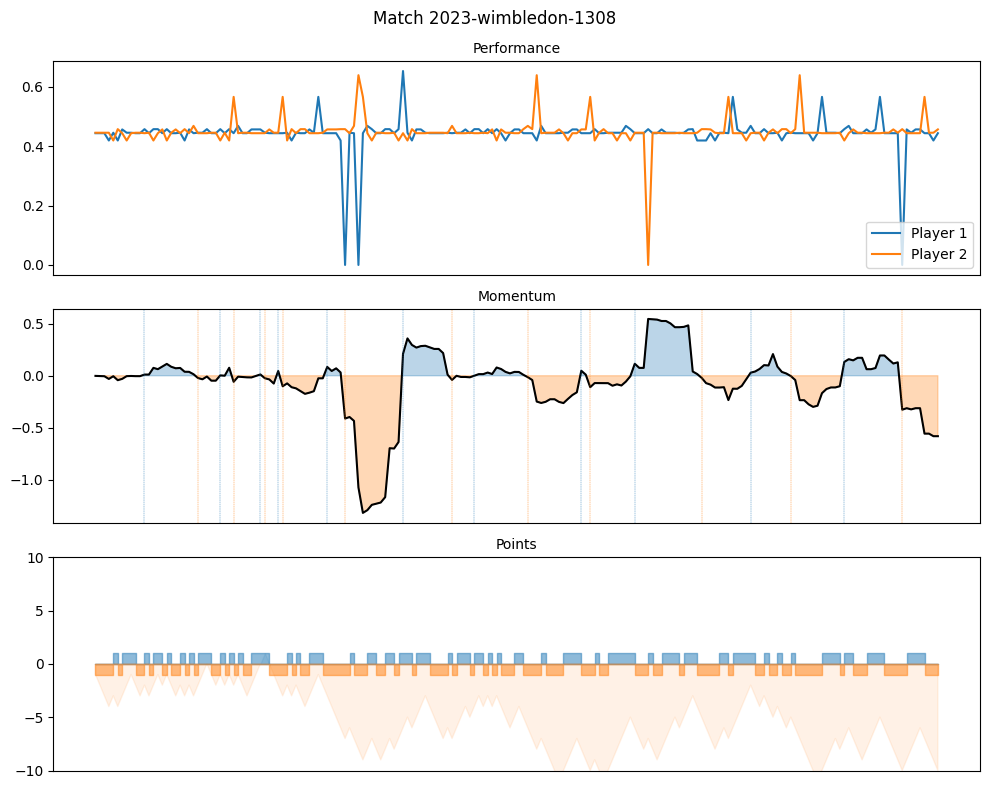

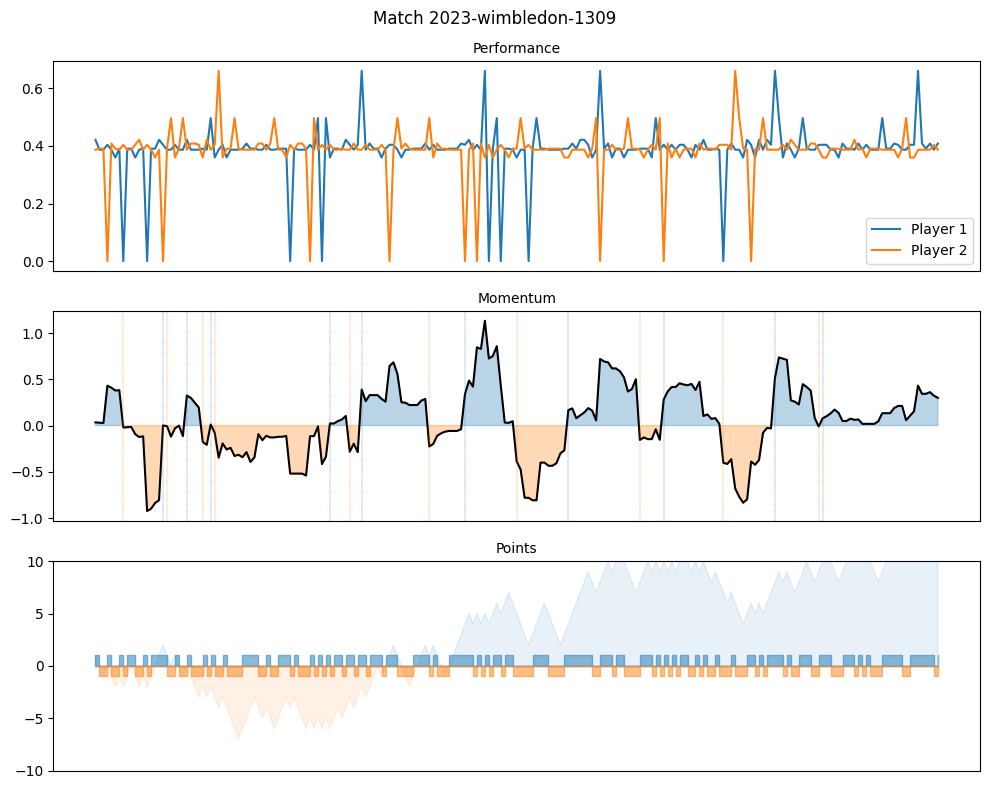

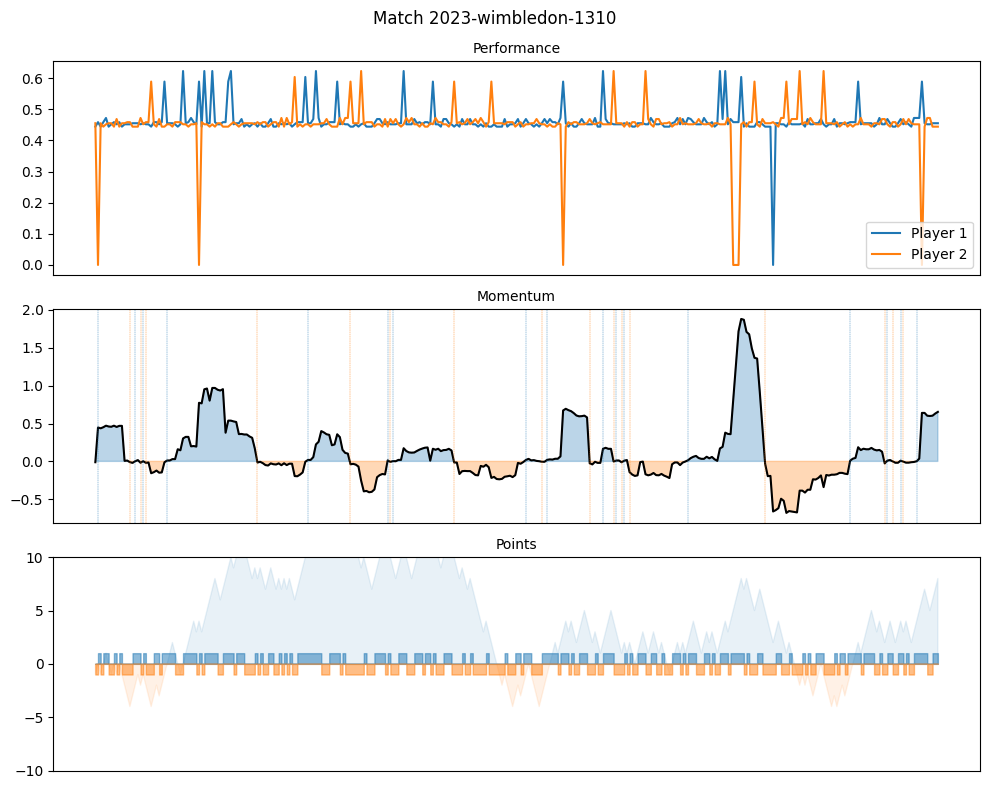

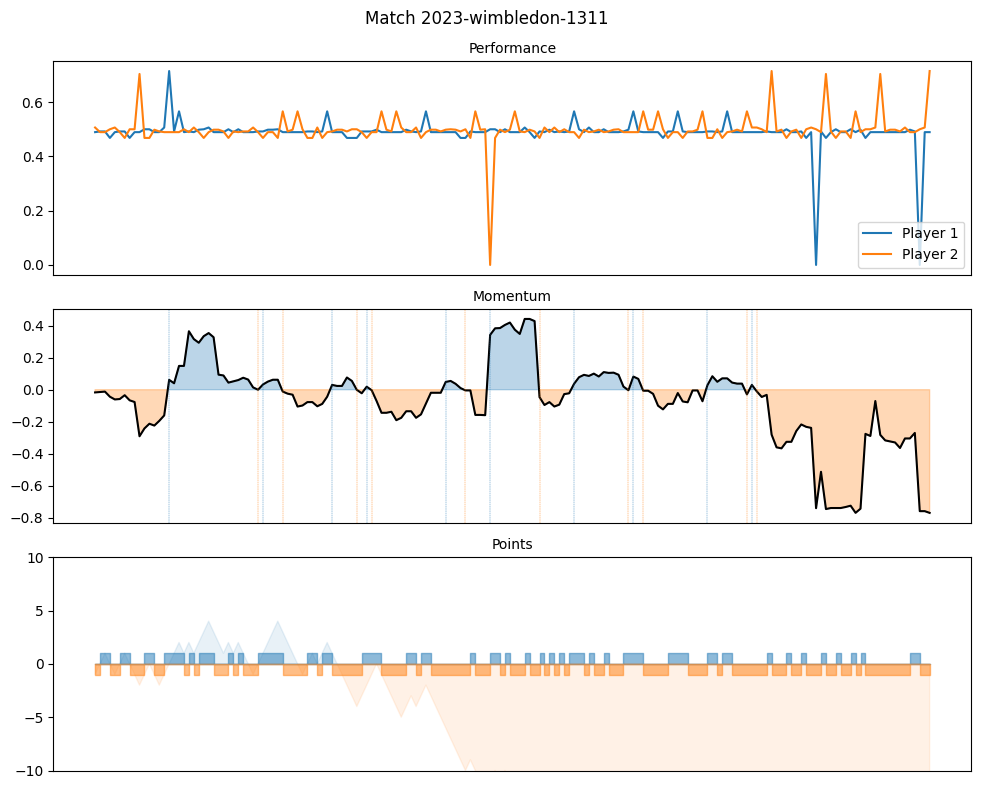

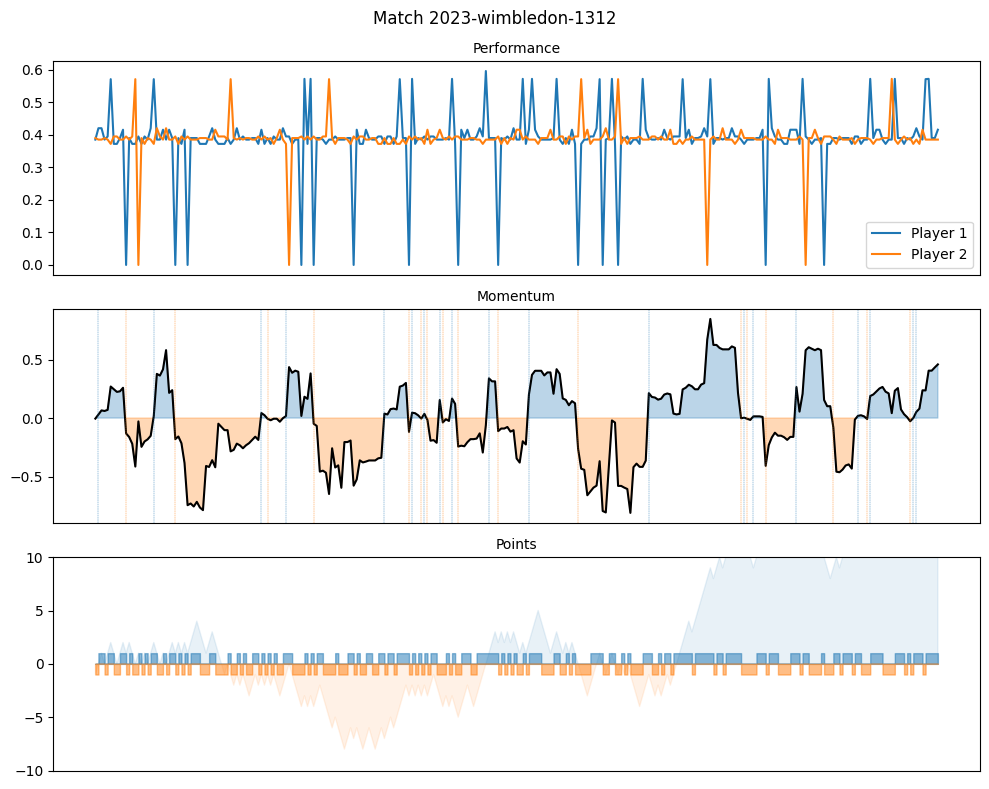

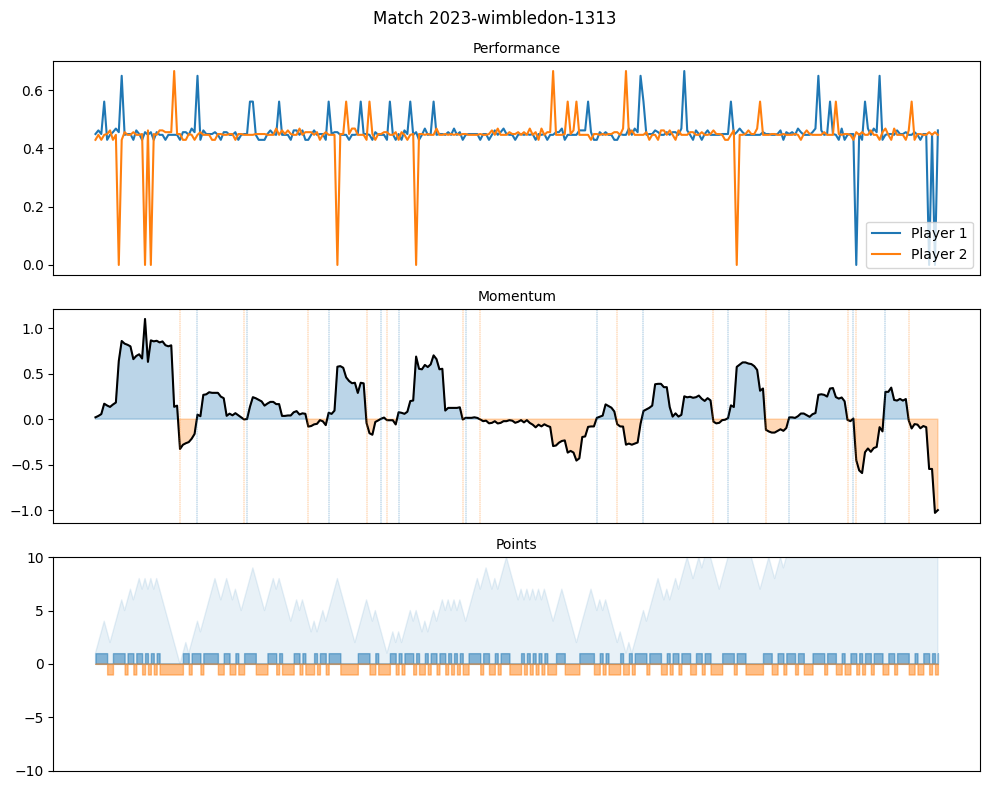

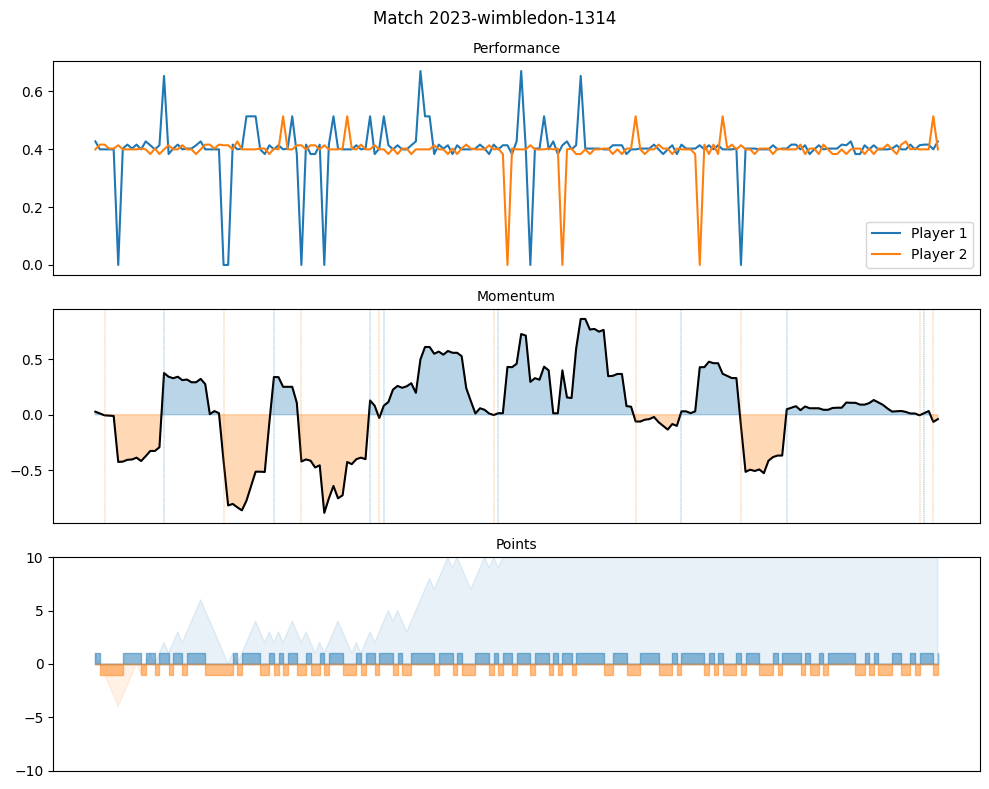

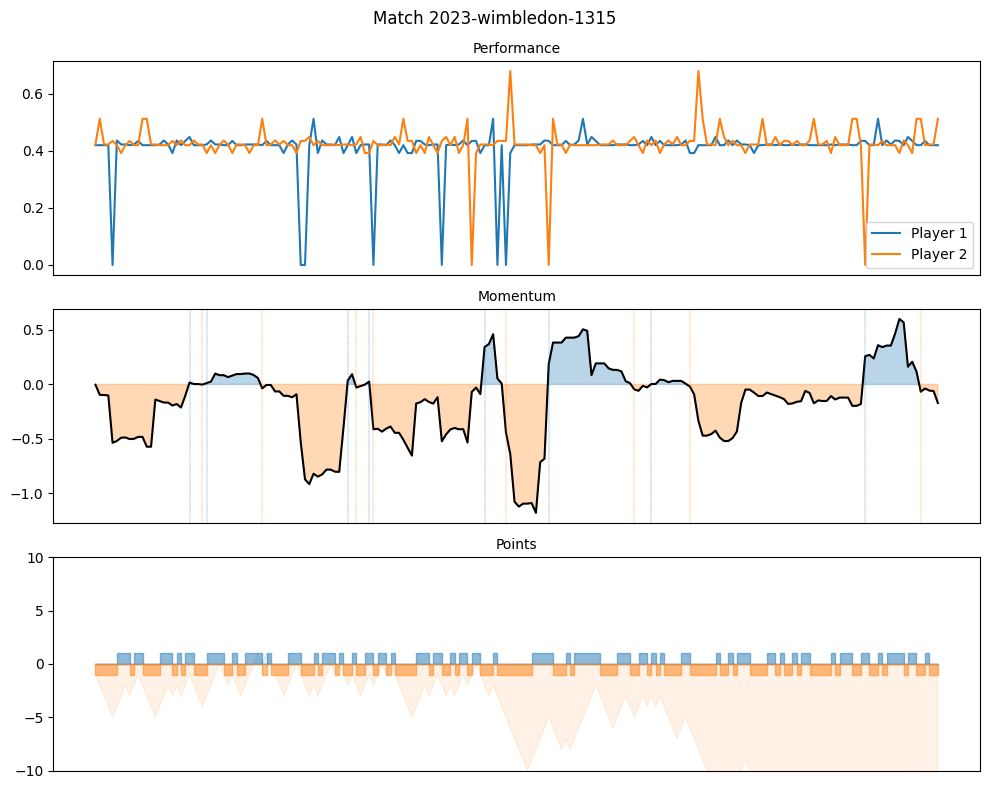

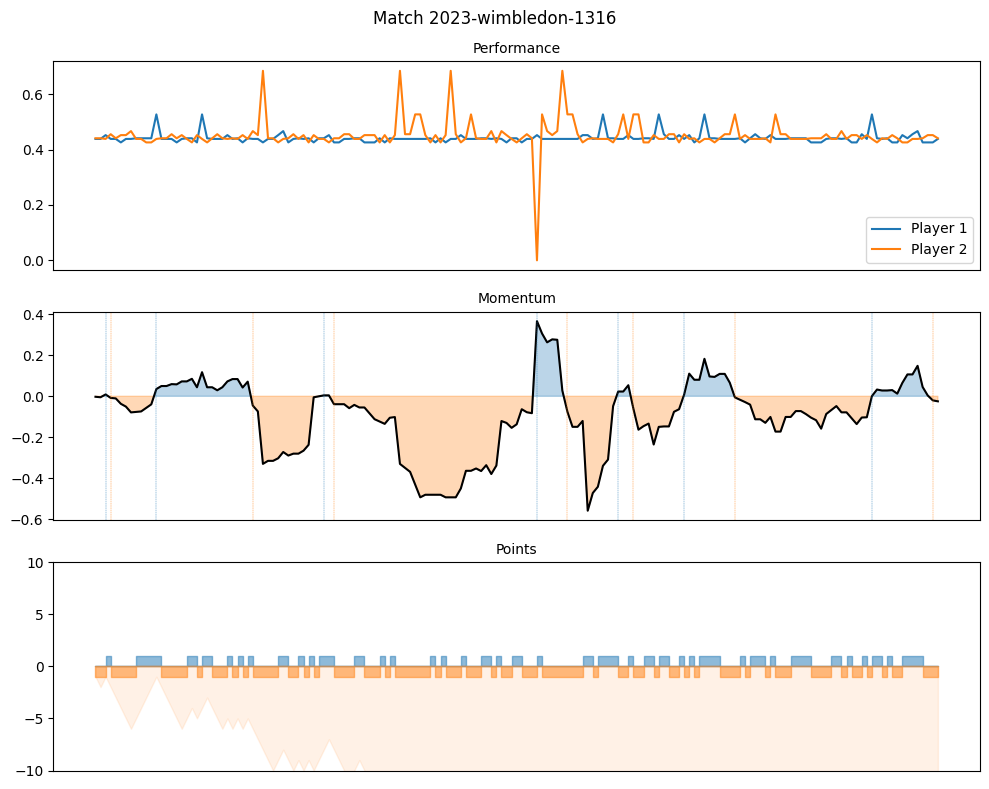

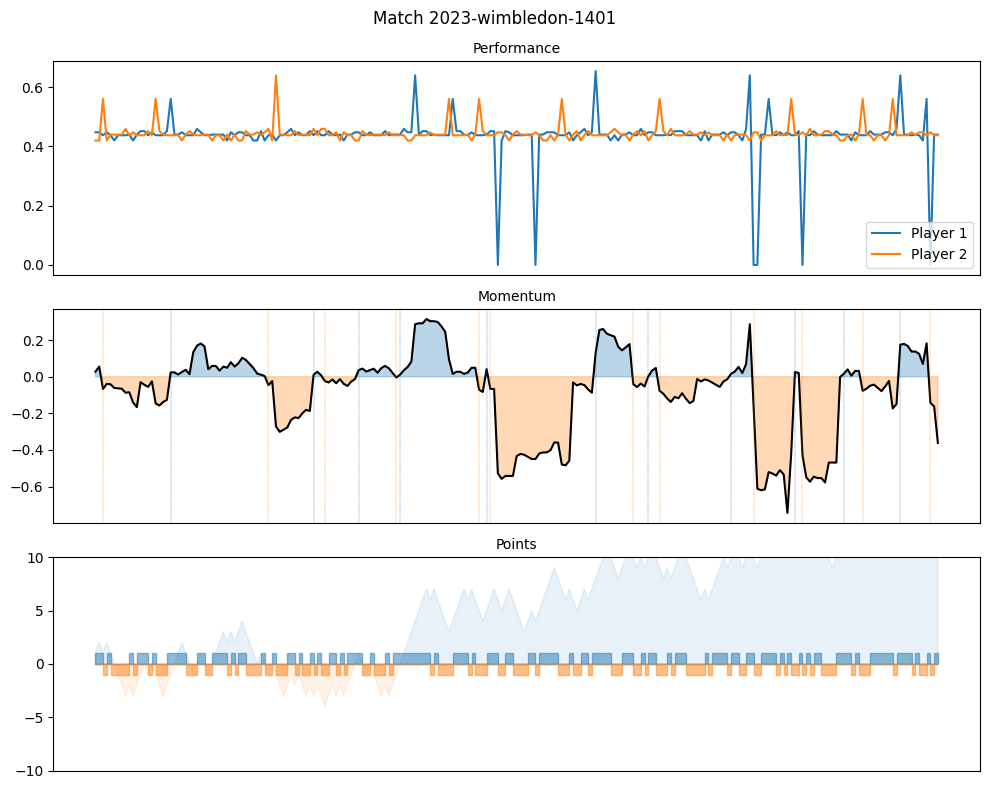

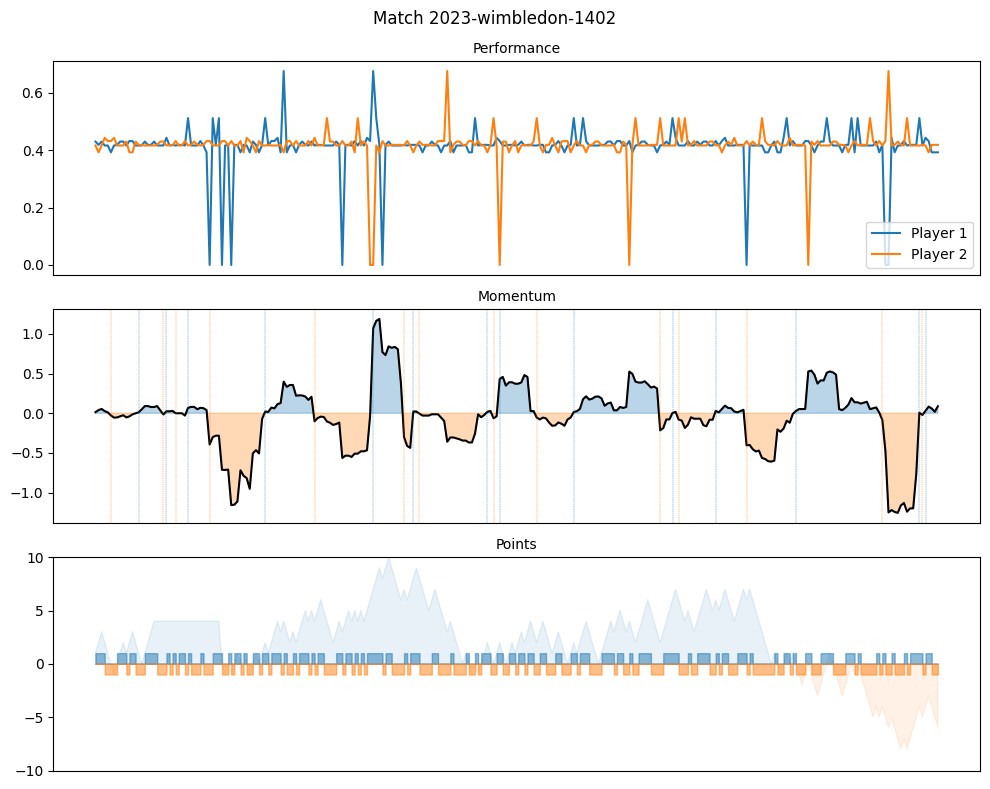

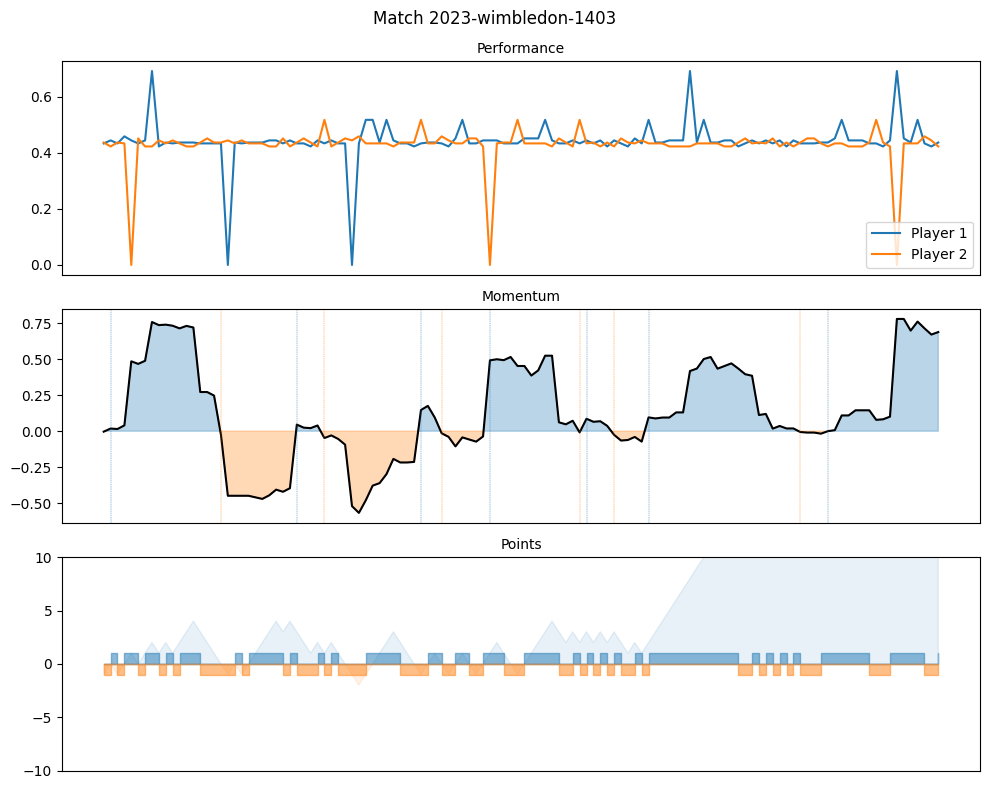

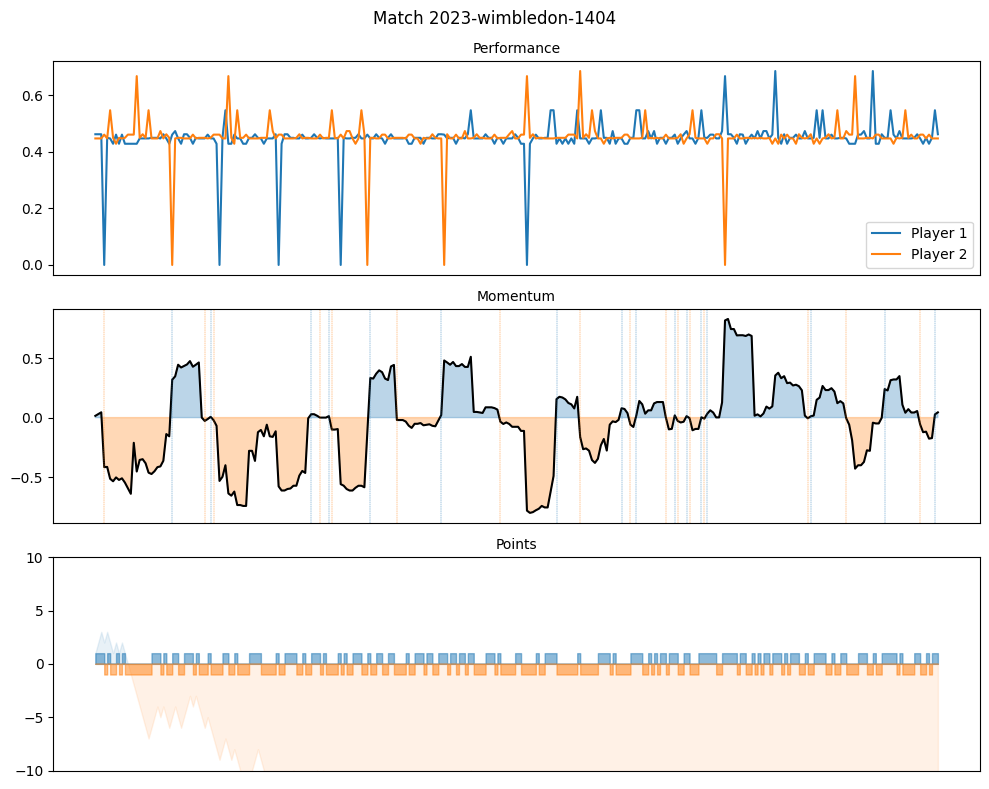

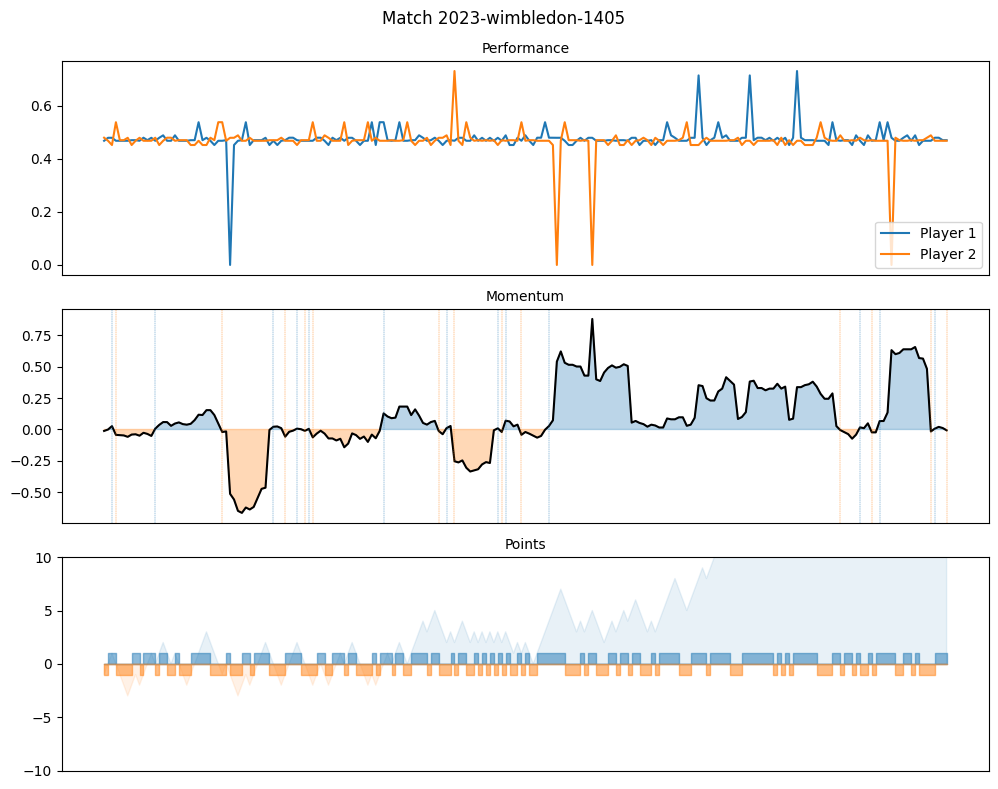

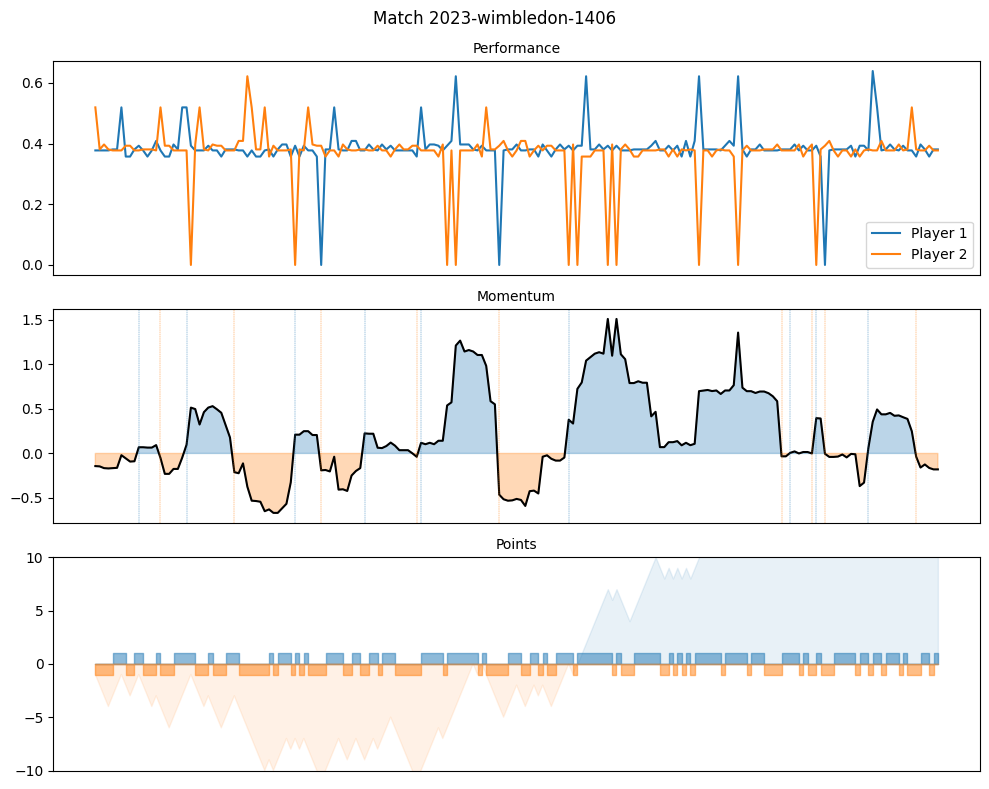

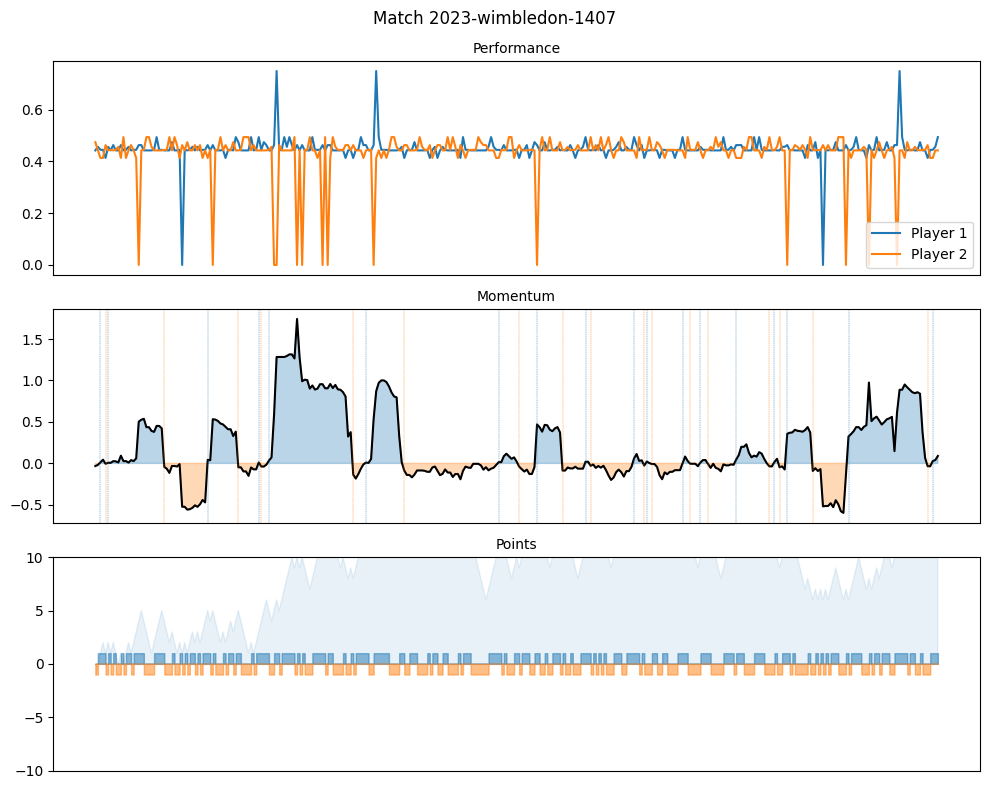

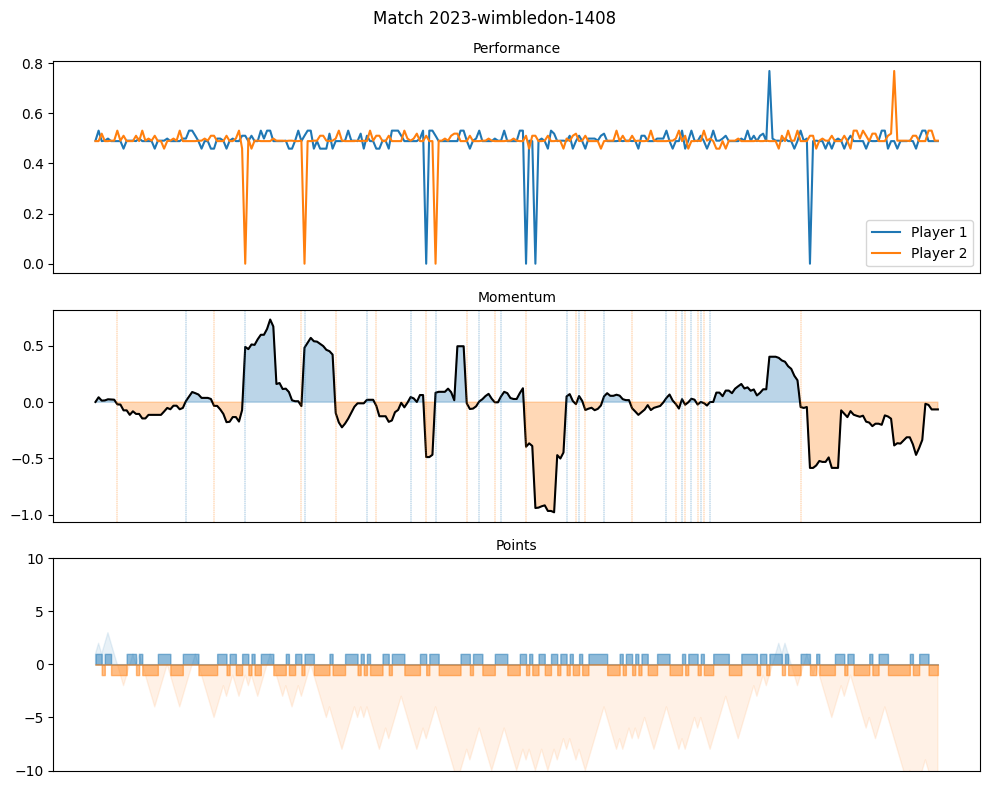

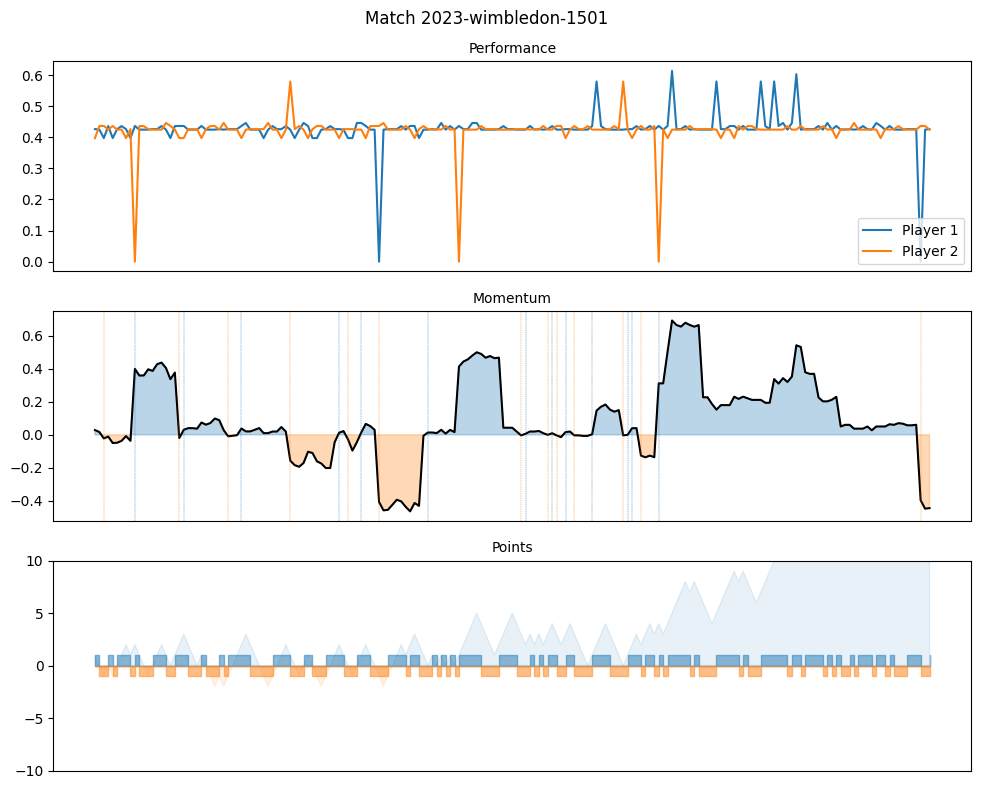

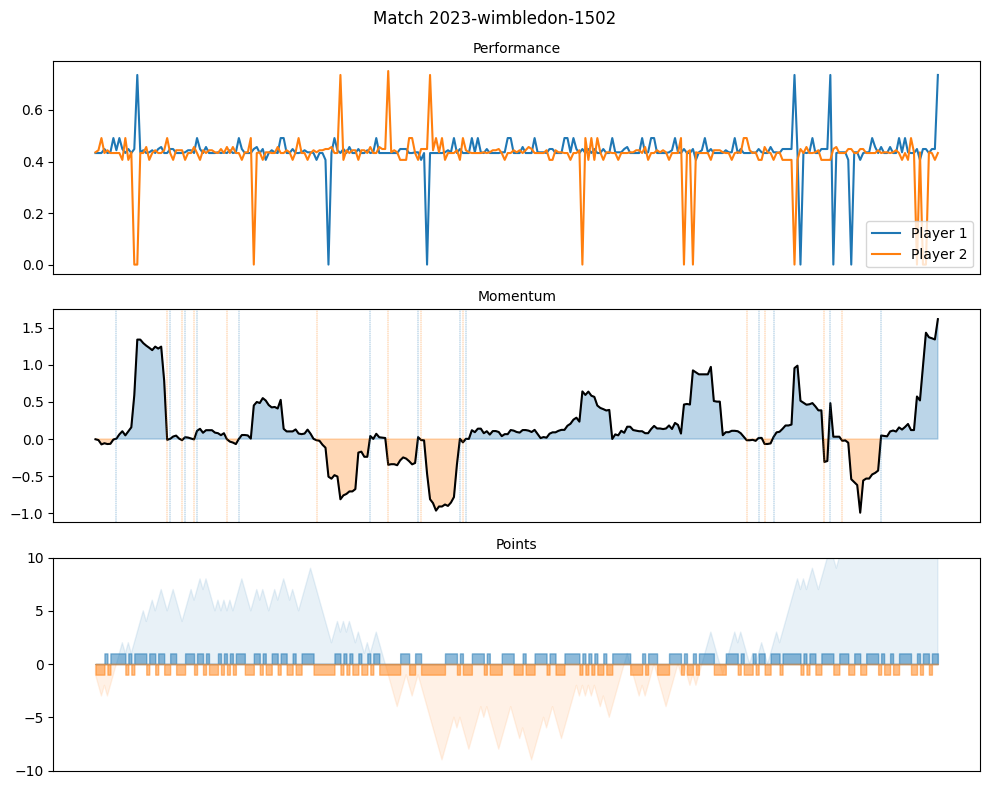

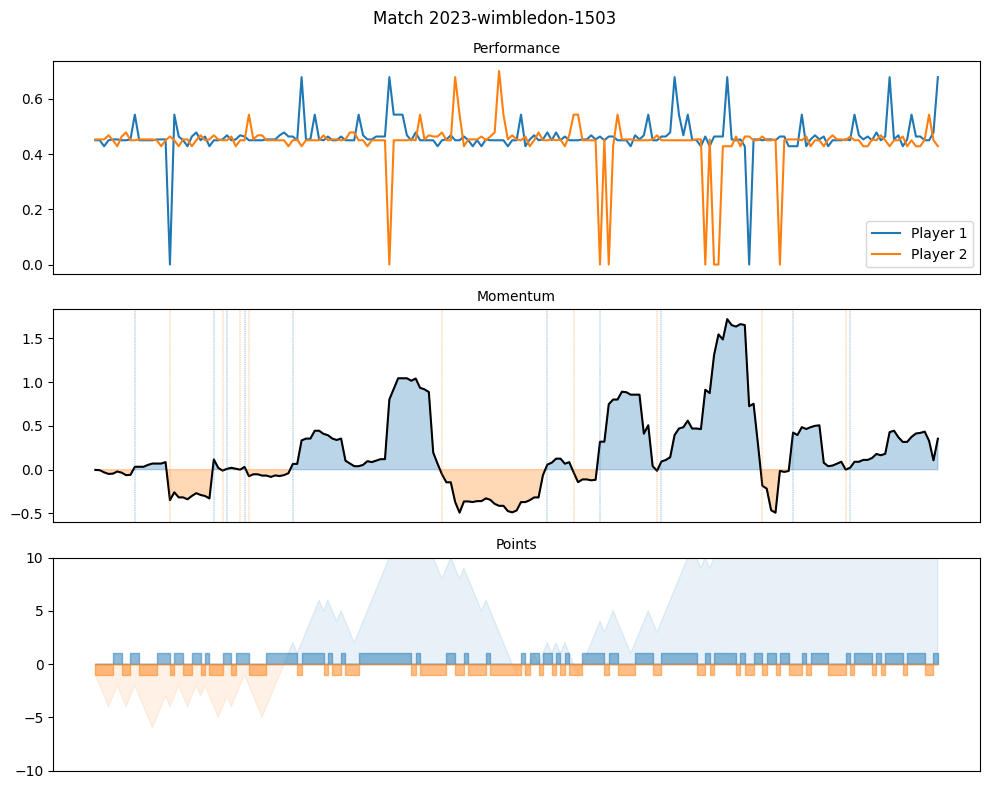

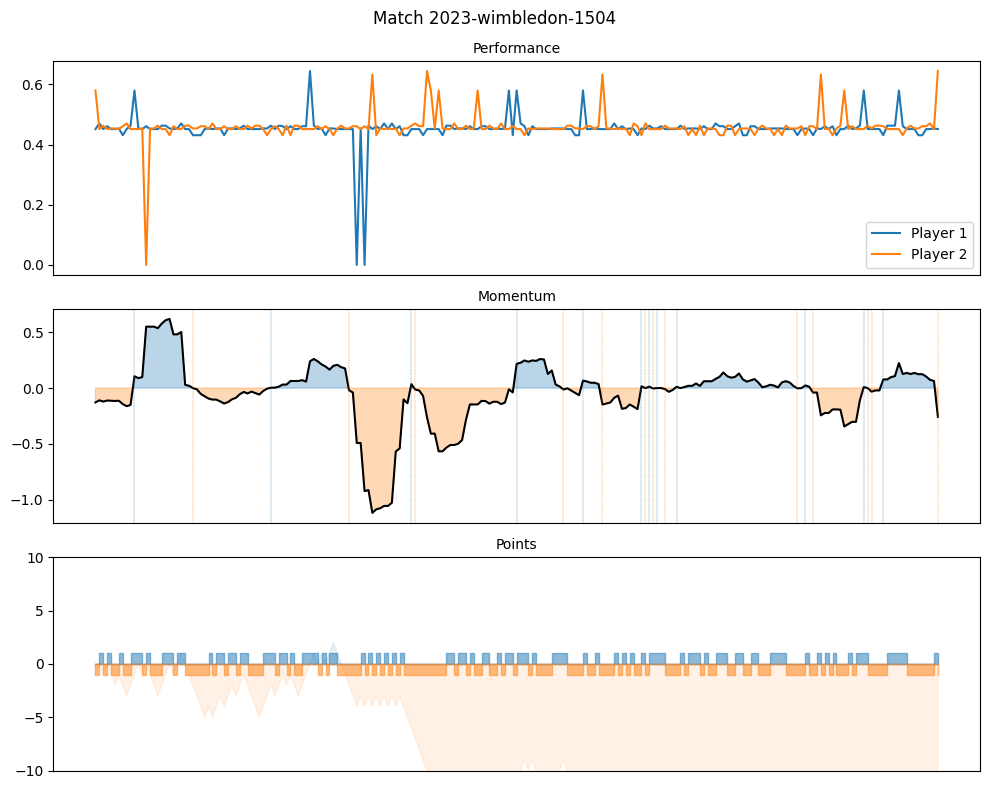

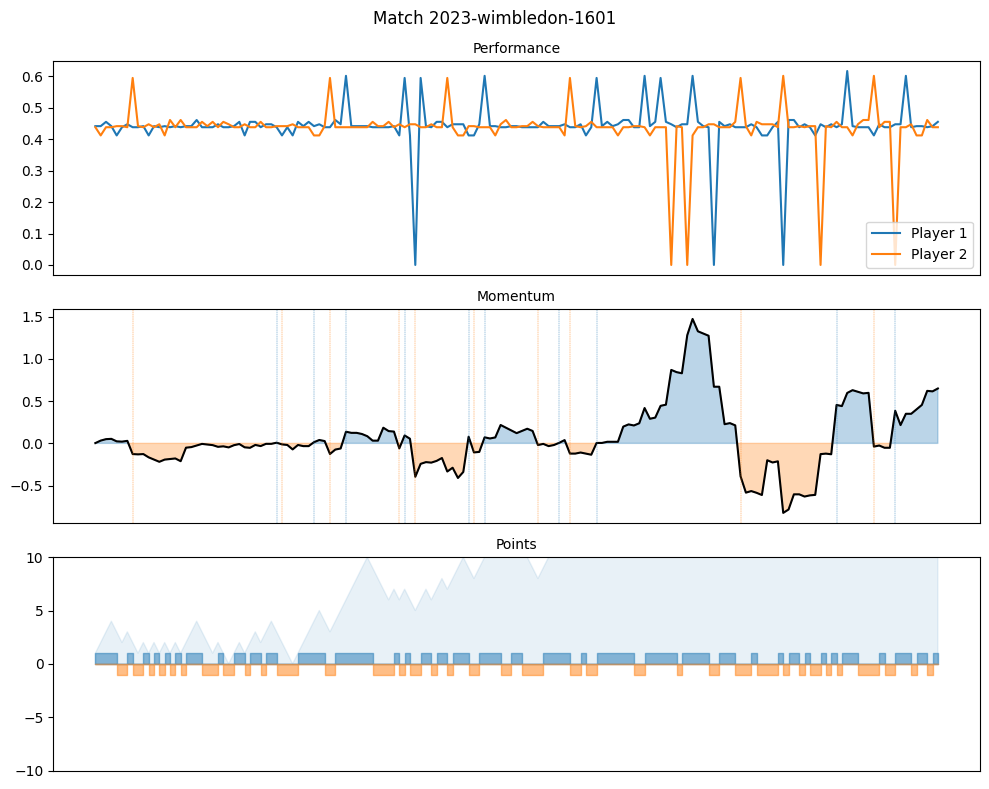

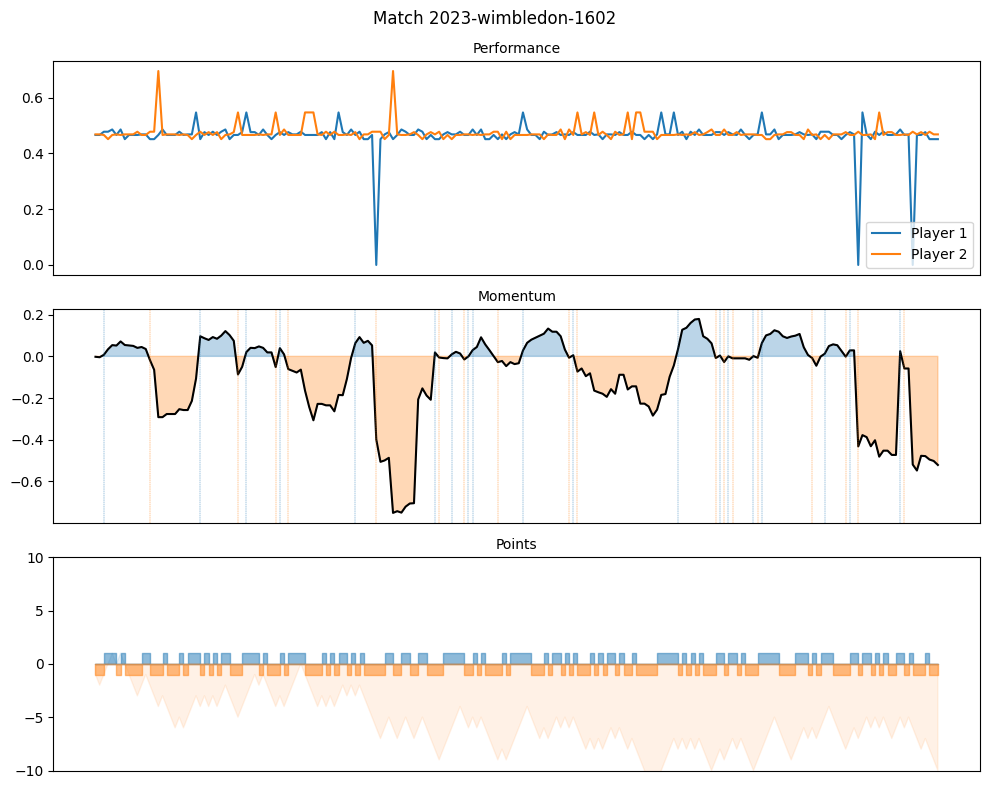

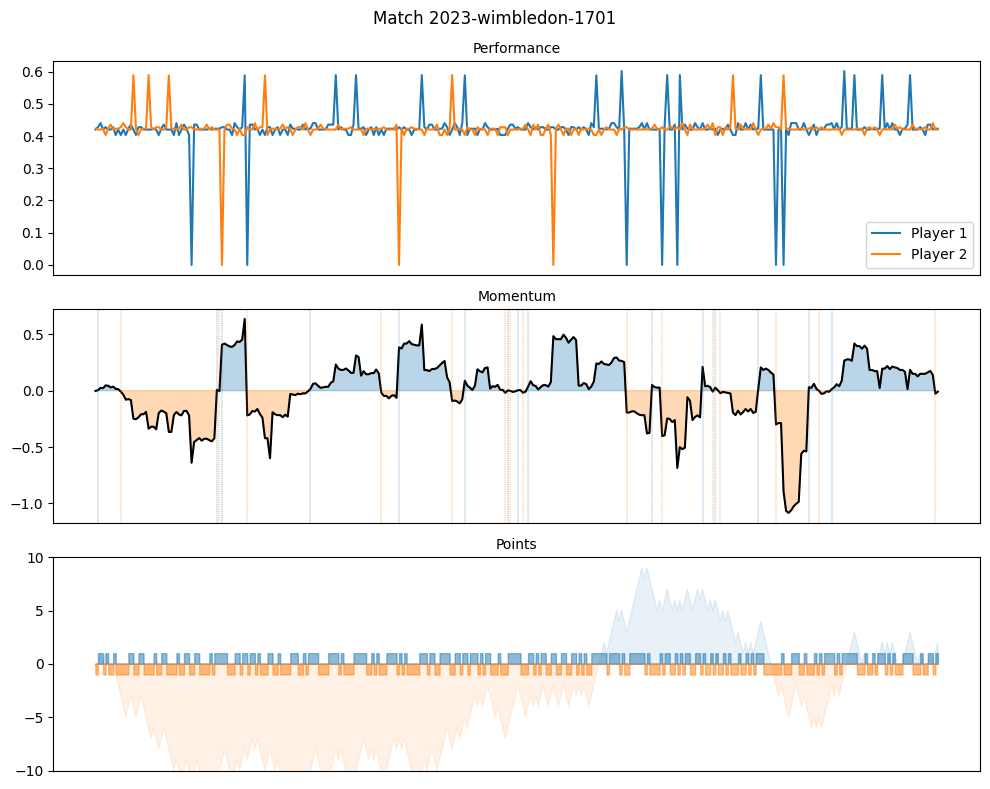

In [6]:
plot_match_info(df, n_samples=None, window_size=10)